In [1]:
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import skimage.io
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [3]:
all_photos, all_attrs = fetch_dataset()

In [4]:
torch.cuda.empty_cache()

In [15]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
# DEVICE = 'cpu'

In [16]:
features = 16

class VAE(nn.Module):
    def __init__(self, features):
        self.features = features
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12288, 512),
            nn.ReLU(),
            nn.Linear(512, self.features * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.features, 512),
            nn.ReLU(),
            nn.Linear(512, 12288)
        )

    def reparametrization(self, mu, log_div):
        std = torch.exp(0.5 * log_div)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample
    
    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated
    
    def forward(self, x):
        x = self.encoder(x).reshape(-1, 2, self.features).type(torch.float32)
        mu = x[:, 0, :] 
        log_var = x[:, 1, :] 
        z = self.reparametrization(mu, log_var).type(torch.float32)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x).reshape(-1, 64, 64, 3)

        return reconstruction, mu, log_var

Loss:
$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [21]:
def KL_divergation(mu, logsigma):
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergation(mu, logsigma) + log_likelihood(x, reconstruction)


In [22]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(all_photos, all_attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [26]:
criterion = loss_vae

autoencoder = VAE(features).to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [27]:
n_epochs = 15

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        batch = batch.to(DEVICE)
        reconstruction, mu, logsigma = autoencoder(batch.float())
        loss = criterion(batch.float(), mu, logsigma, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.inference_mode():
        for batch in val_loader:
          batch = batch.to(DEVICE)
          reconstruction, mu, logsigma = autoencoder(batch.float())
          loss = criterion(batch.float(), mu, logsigma, reconstruction)

    print(f"EPOCH: {epoch + 1}")

  7%|▋         | 1/15 [00:02<00:38,  2.73s/it]

EPOCH: 1


 13%|█▎        | 2/15 [00:05<00:38,  2.97s/it]

EPOCH: 2


 20%|██        | 3/15 [00:08<00:34,  2.87s/it]

EPOCH: 3


 27%|██▋       | 4/15 [00:11<00:31,  2.82s/it]

EPOCH: 4


 33%|███▎      | 5/15 [00:14<00:28,  2.89s/it]

EPOCH: 5


 40%|████      | 6/15 [00:17<00:25,  2.82s/it]

EPOCH: 6


 47%|████▋     | 7/15 [00:19<00:22,  2.82s/it]

EPOCH: 7


 53%|█████▎    | 8/15 [00:22<00:20,  2.89s/it]

EPOCH: 8


 60%|██████    | 9/15 [00:25<00:16,  2.83s/it]

EPOCH: 9


 67%|██████▋   | 10/15 [00:28<00:14,  2.84s/it]

EPOCH: 10


 73%|███████▎  | 11/15 [00:31<00:11,  2.89s/it]

EPOCH: 11


 80%|████████  | 12/15 [00:34<00:08,  2.81s/it]

EPOCH: 12


 87%|████████▋ | 13/15 [00:37<00:05,  2.84s/it]

EPOCH: 13


 93%|█████████▎| 14/15 [00:39<00:02,  2.88s/it]

EPOCH: 14


100%|██████████| 15/15 [00:42<00:00,  2.84s/it]

EPOCH: 15


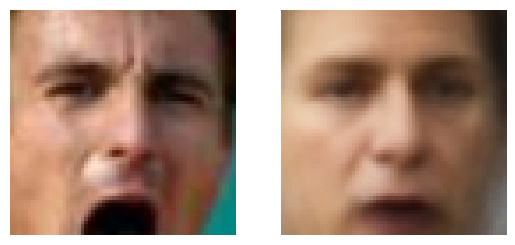

In [166]:
import random

rand_img = random.choice(val_photos)
reconstruction, mu, logsigma = autoencoder(torch.Tensor(rand_img).to(DEVICE).unsqueeze(0))

plt.subplot(1, 2, 1)
plt.imshow(rand_img)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(reconstruction.squeeze(0).cpu().detach().numpy())
plt.axis(False)
plt.show()

tensor([-0.4868,  0.5137,  0.8132, -0.1116,  0.5438,  0.6511, -0.8512, -0.6346,
         0.9160,  1.1074,  0.2729,  2.1175,  1.3754,  1.1569, -1.2383, -0.4460])


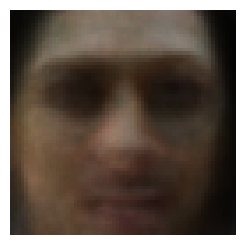

In [193]:
rand_seq = torch.Tensor(np.random.normal(0, 1, features))
print(rand_seq)
img = autoencoder.sample(rand_seq.to(DEVICE))
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(64, 64, 3).cpu().detach().numpy())
plt.axis(False)
plt.show()